## <b><font color='darkblue'>Preface</font></b>
([course link](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/6/human-in-the-loop)) <b><font size='3ptx'>LangChain, a popular open source framework for building LLM applications, recently introduced LangGraph. This extension allows developers to create highly controllable agents in production environments using the populr frameworks like React.</font></b>

![LangGraph idea](images/ch6_1.PNG)

LangGraph models agent workflows uses three components:
* **State**: A shared data structure that denotes the current snapshot of your application.
* **Nodes**: Python functions that define the logic of your agents. They receive the current State as input, perform computation or side-effect, and return an updated State.
* **Edges**: Control flow rules that decide the next Node based on the current State. They can be conditional branches or fixed transitions.

In [1]:
!pip freeze | grep -P '(openai|langchain|langgraph)'

langchain==0.2.6
langchain-anthropic==0.1.15
langchain-community==0.2.6
langchain-core==0.2.10
langchain-experimental==0.0.62
langchain-google-genai==1.0.6
langchain-groq==0.1.3
langchain-openai==0.1.9
langchain-text-splitters==0.2.0
langchainhub==0.1.14
langgraph==0.1.4
openai==1.28.1


In [2]:
import os
import openai
import re
import httpx
import os
from tavily import TavilyClient
from dotenv import load_dotenv, find_dotenv

from openai import OpenAI
from langchain_openai import ChatOpenAI

a = load_dotenv(find_dotenv(os.path.expanduser('~/.env'))) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']
# connect
client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

## <b><font color='darkblue'>Human in the Loop</font></b>

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [4]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [5]:
tool = TavilySearchResults(max_results=2)

### <b><font color='darkgreen'>Manual human approval</font></b>

In [6]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [8]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread_1 = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread_1):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', id='7c48bf66-e45b-4c26-bb1b-bb64fa4ada76'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Hjg8b8WT0raDWkYdgwvIjzjI', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fe69dd77-d21d-4f2f-81aa-ce1771117a9b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_Hjg8b8WT0raDWkYdgwvIjzjI'}], usage_metadata={'input_tokens': 152, 'output_tokens': 22, 'total_tokens': 174})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Hjg8b8WT0raDWkYdgwvIjzjI', 'function': {'arguments': '{"query":"current weather in

We should suspend in the human messaage and wait for next state to execute `"action"`:

In [10]:
abot.graph.get_state(thread_1)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', id='7c48bf66-e45b-4c26-bb1b-bb64fa4ada76'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Hjg8b8WT0raDWkYdgwvIjzjI', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fe69dd77-d21d-4f2f-81aa-ce1771117a9b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_Hjg8b8WT0raDWkYdgwvIjzjI'}], usage_metadata={'input_tokens': 152, 'output_tokens': 22, 'total_tokens': 174})]}, next=('action',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef37af0-c5fc-6024-8001-e2c760ed8d0e'}}, metadata={'source': 'loop',

In [12]:
abot.graph.get_state(thread_1).next

('action',)

### <b><font color='darkgreen'>Continue after interrupt</font></b>
If we pass `input=None` into [graph.stream](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.stream), the execution of graph will continue from the blocking location:

In [13]:
last_event_value = None
for event in abot.graph.stream(None, thread_1):
    for v in event.values():
        print(v)
        last_event_value = v

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_Hjg8b8WT0raDWkYdgwvIjzjI'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://weatherspark.com/h/m/557/2024/1/Historical-Weather-in-January-2024-in-San-Francisco-California-United-States\', \'content\': \'San Francisco Temperature History January 2024\\nHourly Temperature in January 2024 in San Francisco\\nCompare San Francisco to another city:\\nCloud Cover in January 2024 in San Francisco\\nDaily Precipitation in January 2024 in San Francisco\\nObserved Weather in January 2024 in San Francisco\\nHours of Daylight and Twilight in January 2024 in San Francisco\\nSunrise & Sunset with Twilight in January 2024 in San Francisco\\nSolar Elevation and Azimuth in January 2024 in San Francisco\\nMoon Rise, Set & Phases in January 2024 in San Francisco\\nHumidity Comfort Levels in January 2024 in San Francisco\\nWind Speed in January 2024 in San Francisco\\

In [15]:
message = last_event_value['messages'][-1]
print(f'{message.__class__}: {message.content}')

<class 'langchain_core.messages.ai.AIMessage'>: The current weather in San Francisco is 57.0°F with partly cloudy conditions. The wind speed is 6.1 mph coming from the NNW direction. The humidity is at 100%, and the cloud cover is at 25%.


Let's check again the current state and next action:

In [17]:
abot.graph.get_state(thread_1)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', id='7c48bf66-e45b-4c26-bb1b-bb64fa4ada76'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Hjg8b8WT0raDWkYdgwvIjzjI', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 152, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fe69dd77-d21d-4f2f-81aa-ce1771117a9b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_Hjg8b8WT0raDWkYdgwvIjzjI'}], usage_metadata={'input_tokens': 152, 'output_tokens': 22, 'total_tokens': 174}), ToolMessage(content='[{\'url\': \'https://weatherspark.com/h/m/557/2024/1/Historical-Weather-in-January-2024-in-San-Francisco-California-United-S

In [19]:
abot.graph.get_state(thread_1).next

()

We could event interrupt the action and interact with the execution:

In [20]:
messages = [HumanMessage("Whats the weather in Taipei?")]
thread_2 = {"configurable": {"thread_id": "2"}}

for event in abot.graph.stream({"messages": messages}, thread_2):
    for v in event.values():
        print(v)

last_event_value = None
while abot.graph.get_state(thread_2).next:
    print("\n", abot.graph.get_state(thread_2),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread_2):
        for v in event.values():
            print(v)
            last_event_value = v

{'messages': [HumanMessage(content='Whats the weather in Taipei?', id='9ab7e18d-caa7-4ab9-b5f6-08119f9b59c8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_R6sf8WvdSRFW6rAKOxfH4cam', 'function': {'arguments': '{"query":"weather in Taipei"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 152, 'total_tokens': 172}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4a373c7b-53fb-4bdd-9d40-642942c628a1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Taipei'}, 'id': 'call_R6sf8WvdSRFW6rAKOxfH4cam'}], usage_metadata={'input_tokens': 152, 'output_tokens': 20, 'total_tokens': 172})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_R6sf8WvdSRFW6rAKOxfH4cam', 'function': {'arguments': '{"query":"weather in Taipei"}', 'name': 'tavily_search

proceed? y


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Taipei'}, 'id': 'call_R6sf8WvdSRFW6rAKOxfH4cam'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://world-weather.info/forecast/taiwan/taipei/july-2024/\', \'content\': \'Extended weather forecast in Taipei. Hourly Week 10 days 14 days 30 days Year. Detailed ⚡ Taipei Weather Forecast for July 2024 - day/night 🌡️ temperatures, precipitations - World-Weather.info.\'}, {\'url\': \'https://www.weatherapi.com/\', \'content\': \'{\\\'location\\\': {\\\'name\\\': \\\'Taipei\\\', \\\'region\\\': "T\\\'ai-pei", \\\'country\\\': \\\'Taiwan\\\', \\\'lat\\\': 25.04, \\\'lon\\\': 121.53, \\\'tz_id\\\': \\\'Asia/Taipei\\\', \\\'localtime_epoch\\\': 1719841614, \\\'localtime\\\': \\\'2024-07-01 21:46\\\'}, \\\'current\\\': {\\\'last_updated_epoch\\\': 1719841500, \\\'last_updated\\\': \\\'2024-07-01 21:45\\\', \\\'temp_c\\\': 29.1, \\\'temp_f\\\': 84.4, \\\'is_day\\\': 0, \\\'condition\\\': {\\\'text

In [21]:
message = last_event_value['messages'][-1]
print(f'{message.__class__}: {message.content}')

<class 'langchain_core.messages.ai.AIMessage'>: The current weather in Taipei is partly cloudy with a temperature of 29.1°C (84.4°F). The humidity is at 89%, and the wind speed is 3.6 km/h coming from the east-southeast direction. The forecast indicates no precipitation at the moment.


### <b><font color='darkgreen'>Modify State</font></b>
<b><font size='3ptx'>Run until the interrupt and then modify the state.</font></b>

In [22]:
messages = [HumanMessage("Whats the weather in LA?")]
thread_3 = {"configurable": {"thread_id": "3"}}
last_event_value
for event in abot.graph.stream({"messages": messages}, thread_3):
    for v in event.values():
        print(v)
        last_event_value = v

{'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'ta

In [24]:
abot.graph.get_state(thread_3)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef37b0f-cc06-644a-8001-900de5d3caf5'}}, metadata={'source': 'loop', 'step': 1, 'writes'

In [25]:
current_values = abot.graph.get_state(thread_3)

In [27]:
last_message = current_values.values['messages'][-1]
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})

In [28]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Los Angeles'},
  'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}]

In [29]:
_id = last_message.tool_calls[0]['id']

# We use same id to replace message instead of appending.
# and replace query 'weather in Los Angeles' with 'current weather in Louisiana'
current_values.values['messages'][-1].tool_calls = [{
    'name': 'tavily_search_results_json',
    'args': {'query': 'current weather in Louisiana'},
    'id': _id
}]

In [30]:
abot.graph.update_state(thread_3, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}


{'configurable': {'thread_id': '3',
  'thread_ts': '1ef37b1b-85f8-6f46-8002-3cb02abaf7ce'}}

In [34]:
# Confirms that the query has been modified
abot.graph.get_state(thread_3).values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Louisiana'},
  'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}]

In [35]:
last_event_value = None
for event in abot.graph.stream(None, thread_3):
    for v in event.values():
        print(v)
        last_event_value = v

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.wunderground.com/hourly/us/la/grand-cane/date/2024-07-01\', \'content\': \'Current Weather for Popular ... Grand Cane, LA Hourly Weather Forecast star_ratehome. 76 ... Monday 07/01 Hourly for Today, Mon 07/01. Tomorrow 07/01. 51% / 0.14 in .\'}, {\'url\': \'https://www.kplctv.com/2024/07/01/first-alert-forecast-looking-hot-start-week-rain-chances-are-also-improving/\', \'content\': "LAKE CHARLES, La. (KPLC) -We had a hot weekend in SWLA and those high temperatures will continue right into Monday, but rain chances are looking a little better. It\'s kicking off warm and muggy out the door Monday, with sauna-like conditions for many. Heat indices between 100-110 degrees are likely with highs again in the mid 90′s."}]', name='tavily_search_results_json', tool_call_id='call_66C

In [36]:
message = last_event_value['messages'][-1]
print(f'{message.__class__}: {message.content}')

<class 'langchain_core.messages.ai.AIMessage'>: The current weather in Louisiana shows that it is hot with high temperatures expected. Heat indices between 100-110 degrees are likely with highs in the mid-90s.


### <b><font color='darkgreen'>Time Travel</font></b>

In [37]:
states = []
for state in abot.graph.get_state_history(thread_3):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173}), ToolMessage(content='[{\'url\': \'https://www.wunderground.com/hourly/us/la/grand-cane/date/2024-07-01\', \'content\': \'Current Weather for Popular ... Grand 

To fetch the same state as was filmed, the offset below is changed to `-3` from `-1`. This accounts for the initial state `__start__` and the first state that are now stored to state memory with the latest version of software.

In [38]:
to_replay = states[-3]

In [39]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef37b0f-cc06-644a-8001-900de5d3caf5'}}, metadata={'source': 'loop', 'step': 1, 'writes'

In [40]:
to_replay.config

{'configurable': {'thread_id': '3',
  'thread_ts': '1ef37b0f-cc06-644a-8001-900de5d3caf5'}}

In [41]:
last_event_value = None
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)
        last_event_value = v

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.05, \'lon\': -118.24, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1719842676, \'localtime\': \'2024-07-01 7:04\'}, \'current\': {\'last_updated_epoch\': 1719842400, \'last_updated\': \'2024-07-01 07:00\', \'temp_c\': 18.9, \'temp_f\': 66.0, \'is_day\': 1, \'condition\': {\'text\': \'Overcast\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/122.png\', \'code\': 1009}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 10, \'wind_dir\': \'N\', \'pressure_mb\': 1013.0, \'pressure_in\': 29.9, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 84, \'cloud\': 100, \'feelslike_c\': 18.9, \'feelslike_f\': 

In [42]:
message = last_event_value['messages'][-1]
print(f'{message.__class__}: {message.content}')

<class 'langchain_core.messages.ai.AIMessage'>: The current weather in Los Angeles is overcast with a temperature of 66.0°F (18.9°C). The humidity is at 84%, and the wind is coming from the north at 2.2 mph (3.6 km/h). The visibility is 8.0 miles, and the UV index is 6.0.


### <b><font color='darkgreen'>Go back in time and edit</font></b>

In [43]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef37b0f-cc06-644a-8001-900de5d3caf5'}}, metadata={'source': 'loop', 'step': 1, 'writes'

In [44]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
_id

'call_66C5b38T5eAMsfZC5Tdw9fW4'

In [45]:
to_replay.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Los Angeles'},
  'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}]

In [46]:
# Change query from 'weather in Los Angeles' to be 'current weather in LA, accuweather'
to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}]

In [47]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}


In [48]:
last_event_value = None
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)
            last_event_value = v

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.05, \'lon\': -118.24, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1719843131, \'localtime\': \'2024-07-01 7:12\'}, \'current\': {\'last_updated_epoch\': 1719842400, \'last_updated\': \'2024-07-01 07:00\', \'temp_c\': 18.9, \'temp_f\': 66.0, \'is_day\': 1, \'condition\': {\'text\': \'Overcast\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/122.png\', \'code\': 1009}, \'wind_mph\': 2.2, \'wind_kph\': 3.6, \'wind_degree\': 10, \'wind_dir\': \'N\', \'pressure_mb\': 1013.0, \'pressure_in\': 29.9, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 84, \'cloud\': 100, \'feelslike_c\': 18.9, \'fee

In [49]:
message = last_event_value['messages'][-1]
print(f'{message.__class__}: {message.content}')

<class 'langchain_core.messages.ai.AIMessage'>: The current weather in Los Angeles is overcast with a temperature of 66.0°F (18.9°C). The wind speed is 3.6 km/h coming from the north. The humidity is at 84%, and the visibility is 8.0 miles.


### <b><font color='darkgreen'>Add message to a state at a given time</font></b>

In [50]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef37b0f-cc06-644a-8001-900de5d3caf5'}}, metadata={'source': 'loop', 'step':

In [51]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [52]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

In [53]:
branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action")

In [54]:
last_event_value = None
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)
        last_event_value = v

{'messages': [HumanMessage(content='Whats the weather in LA?', id='32248710-6288-46db-9424-d7eaba79920a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3922035f-9554-48a5-8744-4aa74796b4b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_66C5b38T5eAMsfZC5Tdw9fW4'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173}), ToolMessage(content='54 degree celcius', name='tavily_search_results_json', id='7bec14ca-e4ee-4272-ac31-1bbc7759692a', tool_call_id='call_66C5b38T5eAMsfZC5Tdw9fW4'), AIMessage(content='T

In [55]:
message = last_event_value['messages'][-1]
print(f'{message.__class__}: {message.content}')

<class 'langchain_core.messages.ai.AIMessage'>: The weather in Los Angeles is 54 degrees Celsius.


## <b><font color='darkblue'>Extra Practice</font></b>

### <b><font color='darkgreen'>Build a small graph</font></b>
<b><font size='3ptx'>This is a small simple graph you can tinker with if you want more insight into controlling state memory.</font></b>

Define a simple 2 node graph with the following state: -lnode: last node -scratch: a scratchpad location -count : a counter that is incremented each step

In [56]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [57]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {
        "lnode": "node_1",
        "count": 1,
    }
    
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {
        "lnode": "node_2",
        "count": 1,
    }

The graph goes `N1->N2->N1...` but breaks after count reaches 3.

In [58]:
def should_continue(state):
    return state["count"] < 3

In [59]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges(
    "Node2", 
    should_continue, 
    {True: "Node1", False: END})

builder.set_entry_point("Node1")

In [60]:
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

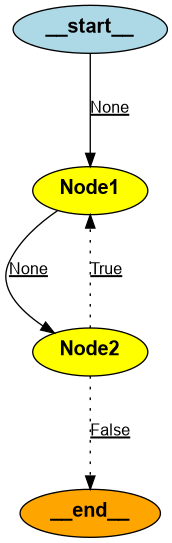

In [62]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

### <b><font color='darkgreen'>Run it!</font></b>
Now, set the thread and run!

In [63]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count":0, "scratch":"Hi"}, thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'Hi', 'count': 4}

### <b><font color='darkgreen'>Look at current state</font></b>
Get the current state. Note the `values` which are the <b><font color='blue'>AgentState</font></b>. Note the `config` and the `thread_ts`. You will be using those to refer to snapshots below.

In [66]:
current_state = graph.get_state(thread)
current_state

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'Hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-462c-6239-8004-be179297b12e'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}}, created_at='2024-07-02T00:45:34.673144+00:00', parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4627-6975-8003-3fc86c2d24d8'}})

In [67]:
current_state.next

()

In [69]:
current_state.values

{'lnode': 'node_2', 'scratch': 'Hi', 'count': 4}

View all the statesnapshots in memory. You can use the displayed `count` agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy `step` variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the `parent_config` is the `config` of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or time travel below.

### <b><font color='darkgreen'>Look at state history</font></b>

In [70]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'Hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-462c-6239-8004-be179297b12e'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}}, created_at='2024-07-02T00:45:34.673144+00:00', parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4627-6975-8003-3fc86c2d24d8'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'Hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4627-6975-8003-3fc86c2d24d8'}}, metadata={'source': 'loop', 'step': 3, 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}}, created_at='2024-07-02T00:45:34.671281+00:00', parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4623-6848-8002-e531cc5fbdc6'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'Hi', 'count': 2}, next=('Node1',), config={'configurable': {'thread_id': '1', 'thread_t

Store just the `config` into an list. Note the sequence of counts on the right. <font color='blue'>get_state_history</font> returns the most recent snapshots first.

In [71]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-462c-6239-8004-be179297b12e'}} 4
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4627-6975-8003-3fc86c2d24d8'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4623-6848-8002-e531cc5fbdc6'}} 2
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4613-6bdb-8001-d813903d5517'}} 1
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-460b-661c-8000-49269bc63914'}} 0
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4603-6231-bfff-be311b6165ef'}} 0


Grab an early state.

In [72]:
states[-3]

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef380c6-4613-6bdb-8001-d813903d5517'}}

This is the state after `Node1` completed for the first time. Note next is `Node2` and count is 1.

In [73]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'Hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4613-6bdb-8001-d813903d5517'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}}, created_at='2024-07-02T00:45:34.663148+00:00', parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-460b-661c-8000-49269bc63914'}})

### <b><font color='darkgreen'>Go Back in Time</font></b>
Use that state in `invoke` to go back in time. Notice it uses `states[-3]` as `current_state` and continues to node2,

In [74]:
graph.invoke(None, states[-3])

node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'Hi', 'count': 4}

Notice the new states are now in state history. Notice the counts on the far right.

In [75]:
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'thread_ts': '1ef380e3-57b0-66c7-8004-61d7639d0a92'}} 4
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380e3-57a8-6df6-8003-9cfc04cc1f8a'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380e3-579d-6fe5-8002-00392bb0703e'}} 2
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-462c-6239-8004-be179297b12e'}} 4
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4627-6975-8003-3fc86c2d24d8'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4623-6848-8002-e531cc5fbdc6'}} 2
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4613-6bdb-8001-d813903d5517'}} 1
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-460b-661c-8000-49269bc63914'}} 0
{'configurable': {'thread_id': '1', 'thread_ts': '1ef380c6-4603-6231-bfff-be311b6165ef'}} 0


You can see the details below. Lots of text, but try to find the node that start the new branch. Notice the parent config is not the previous entry in the stack, but is the entry from `state[-3]`.

In [76]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'Hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380e3-57b0-66c7-8004-61d7639d0a92'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}}, created_at='2024-07-02T00:58:34.972707+00:00', parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380e3-57a8-6df6-8003-9cfc04cc1f8a'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'Hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380e3-57a8-6df6-8003-9cfc04cc1f8a'}}, metadata={'source': 'loop', 'step': 3, 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}}, created_at='2024-07-02T00:58:34.969617+00:00', parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef380e3-579d-6fe5-8002-00392bb0703e'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'Hi', 'count': 2}, next=('Node1',), config={'configurable': {'thread_id': '1', 'thread_t

### <b><font color='darkgreen'>Modify State</font></b>
Let's start by starting a fresh thread and running to clean out history.

In [77]:
thread_2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count":0, "scratch":"hi"},thread_2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

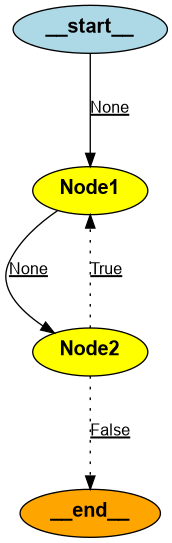

In [78]:
Image(graph.get_graph().draw_png())

In [80]:
states2 = []
for state in graph.get_state_history(thread_2):
    states2.append(state.config)
    print(state.config, state.values['count']) 

{'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-7404-640a-8004-fbb10fa9f2f2'}} 4
{'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73fc-67b1-8003-9cdf36594806'}} 3
{'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73f4-6d3b-8002-1056118b22b1'}} 2
{'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73eb-64ab-8001-7315d4fc4ec8'}} 1
{'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73e1-62a3-8000-f94b9c683622'}} 0
{'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73d7-6b61-bfff-4b29656a158d'}} 0


Start by grabbing a state.

In [81]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73eb-64ab-8001-7315d4fc4ec8'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}}, created_at='2024-07-02T01:01:45.837638+00:00', parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73e1-62a3-8000-f94b9c683622'}})

Now modify the values. One subtle item to note: Recall when agent state was defined, `count` used `operator.add` to indicate that values are added to the current value. Here, `-3` will be added to the current count value rather than replace it.

In [82]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73eb-64ab-8001-7315d4fc4ec8'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}}, created_at='2024-07-02T01:01:45.837638+00:00', parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73e1-62a3-8000-f94b9c683622'}})

Now update the state. This creates a new entry at the top, or latest entry in memory. This will become the current state.

In [84]:
graph.update_state(thread_2, save_state.values)

{'configurable': {'thread_id': '2',
  'thread_ts': '1ef380ef-7cca-63dc-8005-639a159d4824'}}

Current state is at the top. You can match the `thread_ts`. Notice the `parent_config`, `thread_ts` of the new node - it is the previous node.

In [86]:
for i, state in enumerate(graph.get_state_history(thread_2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ef-7cca-63dc-8005-639a159d4824'}}, metadata={'source': 'update', 'step': 5, 'writes': {'Node2': {'lnode': 'node_1', 'scratch': 'hello', 'count': -3}}}, created_at='2024-07-02T01:04:00.985582+00:00', parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-7404-640a-8004-fbb10fa9f2f2'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-7404-640a-8004-fbb10fa9f2f2'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}}, created_at='2024-07-02T01:01:45.847890+00:00', parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-73fc-67b1-8003-9cdf36594806'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'

### <b><font color='darkgreen'>Try again with `as_node`</font></b>
When writing using <font color='blue'>update_state()</font>, you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the <font color='blue'>next()</font> value is computed by travesing the graph using the new state. In this case, the state we have was written by `Node1`. The graph can then compute the next state as being `Node2`. Note that in some graphs, this may involve going through conditional edges! Let's try this out.

In [87]:
graph.update_state(thread_2, save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'thread_ts': '1ef380f6-0a11-61d9-8006-29e9cb7f8867'}}

In [89]:
for i, state in enumerate(graph.get_state_history(thread_2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380f6-0a11-61d9-8006-29e9cb7f8867'}}, metadata={'source': 'update', 'step': 6, 'writes': {'Node1': {'lnode': 'node_1', 'scratch': 'hello', 'count': -3}}}, created_at='2024-07-02T01:06:56.860797+00:00', parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ef-7cca-63dc-8005-639a159d4824'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ef-7cca-63dc-8005-639a159d4824'}}, metadata={'source': 'update', 'step': 5, 'writes': {'Node2': {'lnode': 'node_1', 'scratch': 'hello', 'count': -3}}}, created_at='2024-07-02T01:04:00.985582+00:00', parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380ea-7404-640a-8004-fbb10fa9f2f2'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(),

`invoke` will run from the current state if not given a particular `thread_ts`. This is now the entry that was just added.

In [90]:
graph.invoke(None, thread_2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

Print out the state history, notice the `scratch` value change on the latest entries.

In [91]:
for state in graph.get_state_history(thread_2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380f8-6889-6851-800b-38fa1534e691'}}, metadata={'source': 'loop', 'step': 11, 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}}, created_at='2024-07-02T01:08:00.453819+00:00', parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380f8-6880-6143-800a-6470ec788a9a'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380f8-6880-6143-800a-6470ec788a9a'}}, metadata={'source': 'loop', 'step': 10, 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}}, created_at='2024-07-02T01:08:00.449963+00:00', parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef380f8-687a-6e84-8009-558b54eb5090'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2'

## <b><font color='darkblue'>Supplement</font></b>
* [Deeplearn.ai - AI Agents in LangGraph - Ch2: Build an Agent from Scratch](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/2/build-an-agent-from-scratch)
* [Deeplearn.ai - AI Agents in LangGraph - Ch3: LangGraph components](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/3/langgraph-components)
* [Deeplearn.ai - AI Agents in LangGraph - Ch4: Agentic search tools](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/4/agentic-search-tools)
* [Deeplearn.ai - AI Agents in LangGraph - Ch5: Persistence and streaming](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/5/persistence-and-streaming)
* [Deeplearn.ai - AI Agents in LangGraph - Ch6: Human in the loop](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/6/human-in-the-loop)
* [Deeplearn.ai - AI Agents in LangGraph - Ch7: Essay Writer](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/7/essay-writer)
* [LangGraph examples/chat_agent_executor_with_function_calling/human-in-the-loop.ipynb](https://github.com/langchain-ai/langgraph/blob/main/examples/chat_agent_executor_with_function_calling/human-in-the-loop.ipynb)
> In this example we will build a ReAct Agent that has a human in the loop. We will use the human to approve specific actions.
* [Medium - Exploring AI Automation: Agentic Workflows with LangGraph and Tavily](https://medium.com/@LakshmiNarayana_U/exploring-ai-automation-agentic-workflows-with-langgraph-and-tavily-155f5442a999)